### SIMPLE CNN Implementation

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
from sklearn.datasets import load_sample_image

In [9]:
china  = load_sample_image("china.jpg")/255
flower  = load_sample_image("flower.jpg")/255

In [10]:
image = np.array([china,flower])
batch_size, height,width,channels = image.shape

In [11]:
# Create 2 Filter 

In [12]:
filters = np.zeros(shape=(7,7,channels,2),dtype=np.float32)
filters[:,3,:,0]=1 #vertical line 
filters[3,:,:,1] =1 # horizontal Line  

In [13]:
output = tf.nn.conv2d(image,filters,strides=1,padding="SAME")

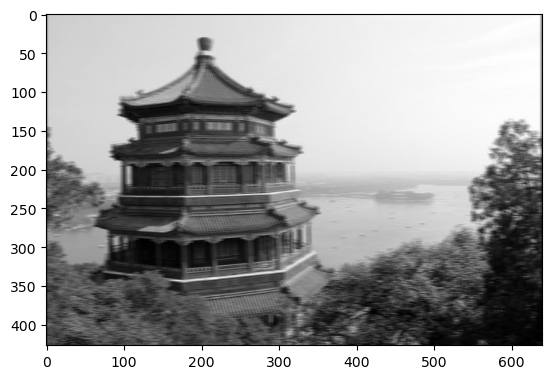

In [14]:
plt.imshow(output[0,:,:,1],cmap="gray") # plot 1st image's  , 2nd feature map
plt.show()

## Pooling Layers 

In [15]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)


In [16]:
output=max_pool(image)

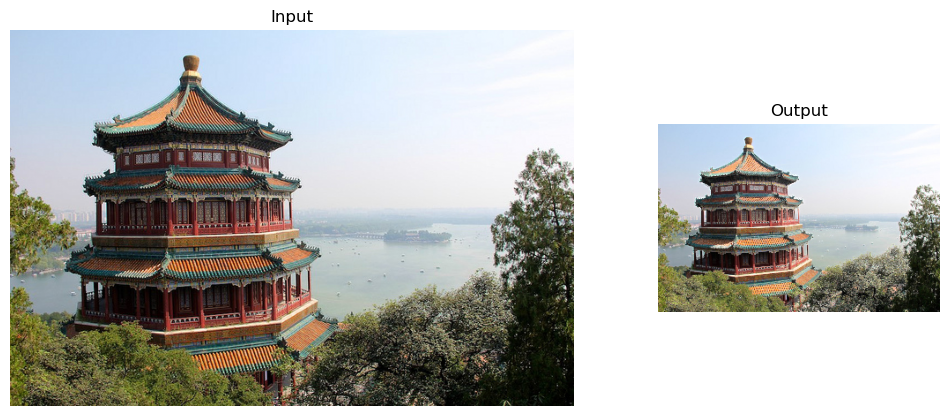

In [17]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(image[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Depth-wise pooling 

In [18]:
np.random.seed(42)
fmaps = np.random.rand(2,70,120,60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps,ksize=(1,1,1,3),strides=(1,1,1,3),padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [19]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [20]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

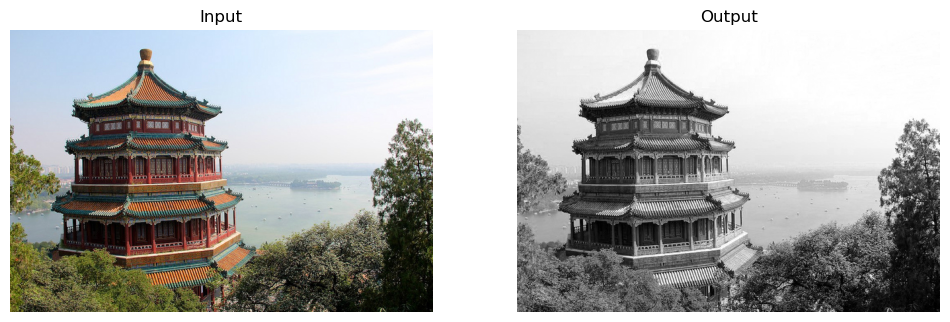

In [21]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(image)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(image[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()


GLobal Average Pooling 


In [22]:
global_avg_pool= tf.keras.layers.GlobalAveragePooling2D()


In [23]:
# The following layer is equivalent 
global_avg_pool = tf.keras.layers.Lambda(
    lambda X:tf.reduce_mean(X,axis=[1,2])
)

In [24]:
global_avg_pool(image)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.56767327, 0.5706355 , 0.5528319 ],
       [0.21627817, 0.28856644, 0.2232219 ]], dtype=float32)>

### CNN Architectures

In [25]:
# load the MNist fashion datasets 
mnist = tf.keras.datasets.fashion_mnist.load_data()

In [26]:
(X_train_full , y_train_full),(X_test,y_test) = mnist

# This is the common preprocessing method of Deep Learning  when working  with grayscale data like mnist  ,mnist-fashion  
X_train_full = np.expand_dims(X_train_full,axis=-1).astype(np.float32)/255 # used the np.expand_dims for adding extra dims at the end of array 
#because before adding the dims at end array looks like (60000,28,28) so tensorflow required the input_format in (batch_size , channels , height, width) 
# thus we need to change it and add '1' at end of the array 
y_train_full = np.expand_dims(y_train_full,axis=-1).astype(np.float32)/255

In [27]:
X_train ,X_valid = X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid = y_train_full[:-5000],y_train_full[-5000:]

In [28]:
from functools import partial
tf.random.set_seed(42)
DefaultConv2D  = partial (tf.keras.layers.Conv2D,kernel_size=3,padding="same",
                          activation="relu",kernel_initializer = "he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64,kernel_size=7,input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(), # reshape the data in 1D vector ,it doesn't change data  
    tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10,activation="softmax")
    
])

/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# extra code for compile and run the model training
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
history= model.fit(X_train,y_train,epochs=10,
                   validation_data=(X_valid,y_valid))
score = model.evaluate(X_test,y_test)
X_new = X_test[:10] #pretend we have new images 
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 158s 91ms/step - accuracy: 0.0975 - loss: 0.0449 - val_accuracy: 0.1042 - val_loss: 0.0000e+00
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 180s 105ms/step - accuracy: 0.0984 - loss: 3.6982e-04 - val_accuracy: 0.1042 - val_loss: 0.0000e+00
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 182s 106ms/step - accuracy: 0.0984 - loss: 1.5307e-04 - val_accuracy: 0.1042 - val_loss: 0.0000e+00
Epoch 4/10
 813/1719 ━━━━━━━━━━━━━━━━━━━━ 1:47 119ms/step - accuracy: 0.0975 - loss: 2.7066e-10

KeyboardInterrupt: 

### LeNe-5 Architecture Implemetation 



#### mostly used for MNIST Datasets , it use for handwritten character detection 

In [30]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="tanh", input_shape=(32, 32, 1)),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="tanh"),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=120, kernel_size=5, activation="tanh"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84, activation="tanh"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

### AlexNet Architecture Implementation


#### Where AlexNet is/was mostly used:

* Large-scale image classification tasks (like ImageNet — 1 million+ images, 1000 classes)
* Feature extraction: use pretrained AlexNet layers to extract features and feed them into other models (called transfer learning).
* Object detection: early versions of detection models (like RCNN) used AlexNet as the backbone feature extractor.
* Medical imaging: classification tasks where large datasets are available.
* Research and education: it’s often used to teach CNN basics because it’s simple yet powerful.

In [31]:
import tensorflow as tf

model = tf.keras.Sequential([
    # 1st Convolutional Layer
    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    # 2nd Convolutional Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    # 3rd Convolutional Layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding="same", activation='relu'),

    # 4th Convolutional Layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding="same", activation='relu'),

    # 5th Convolutional Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Flatten(),

    # 1st Fully Connected Layer
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # 2nd Fully Connected Layer
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(units=1000, activation='softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,378,344 (237.95 MB)

 Trainable params: 62,378,344 (237.95 MB)

 Non-trainable params: 0 (0.00 B)

### Res-Net-34 Architecture

In [32]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,
                        padding="same",kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self,filters,strides=1,activation="relu",**kwargs):
        super().__init__(*kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers=[
            DefaultConv2D(filters,strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
            
        ]
        self.skip_layers=[]
        if strides>1:
            self.skip_layers=[
                DefaultConv2D(filters,kernel_size=1,strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
        
        
    def call(self,inputs):
        z= inputs
        for layer in self.main_layers:
            z=layer(z)
        skip_z= inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        return self.activation(z+skip_z)        

In [33]:
model = tf.keras.Sequential([
    DefaultConv2D(64,kernel_size=7,strides=2,input_shape=[224,224,31]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same"),
])
prev_filters= 64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
    strides= 1 if filters==prev_filters else 2
    model.add(ResidualUnit(filters,strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation="softmax"))

### Using Pretrained Models from Keras 

In [34]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [35]:
from sklearn.datasets import load_sample_images
K = tf.keras.backend
images = K.constant(load_sample_images()["images"])
images_resized = tf.keras.layers.Resizing(height=224,width=224,
                                         crop_to_aspect_ratio=True)(images)

In [36]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [37]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


(2, 1000)

In [38]:
top_k= tf.keras.applications.resnet50.decode_predictions(Y_proba,top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id , name, y_proba in top_k[image_index]:
        print(f" {class_id}-{name:12s} {y_proba:.2%}")

Image #0
 n03877845-palace       54.69%
 n03781244-monastery    24.72%
 n02825657-bell_cote    18.55%
Image #1
 n04522168-vase         32.66%
 n11939491-daisy        17.81%
 n03530642-honeycomb    12.06%


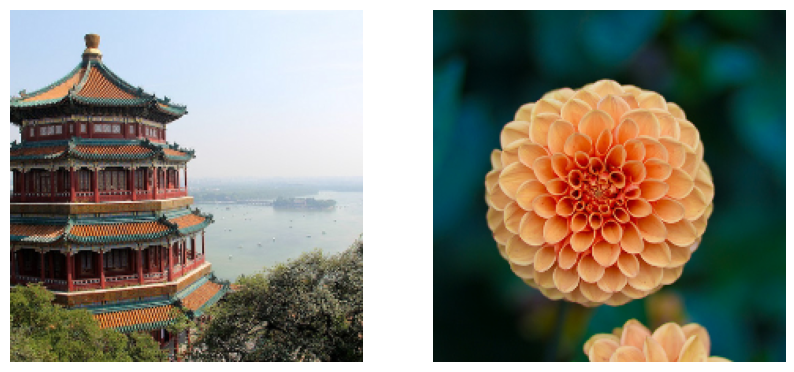

In [39]:
# display the croped and resized images 

plt.figure(figsize=(10,6))
for idx in (0,1):
    plt.subplot(1,2,idx+1)
    plt.imshow(images_resized[idx]/255)
    plt.axis("off")
plt.show()

### PreTrained Models For Transfer Learning 

In [40]:
import tensorflow_datasets as tfds 
datasets, info = tfds.load("tf_flowers",as_supervised=True,with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [41]:
dataset_size

3670

In [42]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [43]:
n_classes

5

In [44]:
test_set_raw,valid_set_raw,train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]","train[10%:25%]","train[25%:]"],
    as_supervised=True
)

2025-05-23 18:15:19.742544: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-23 18:15:19.745073: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


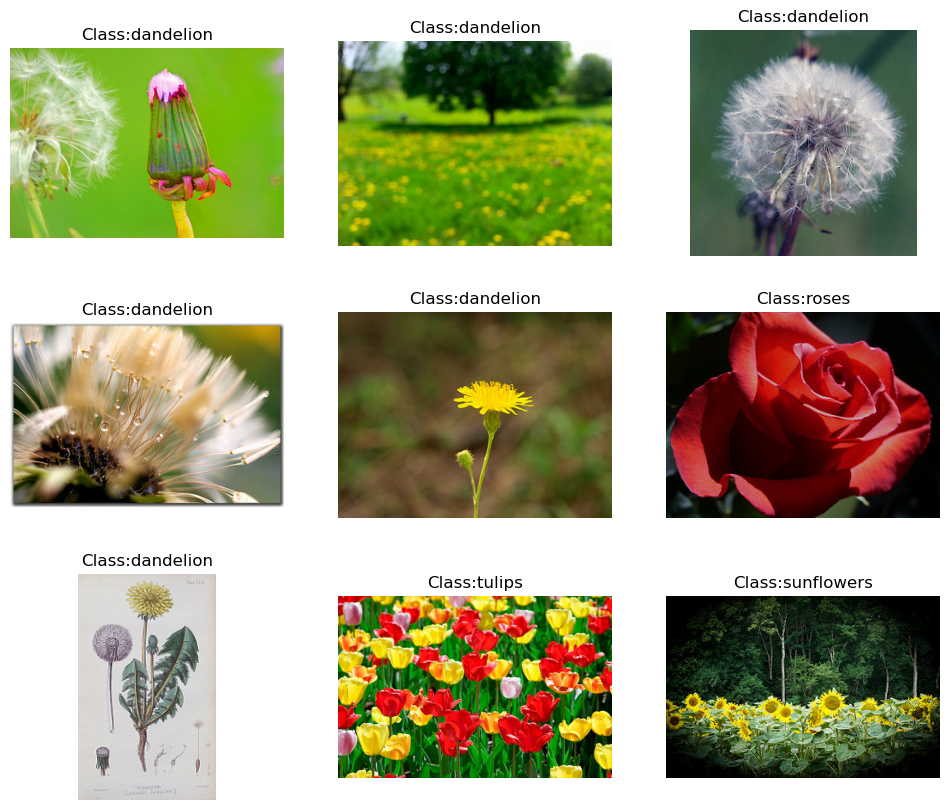

In [45]:
plt.figure(figsize=(12,10))
index=0
for image , label in valid_set_raw.take(9):
    index+=1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title(f"Class:{class_names[label]}")
    plt.axis("off")
plt.show()

In [46]:
tf.keras.backend.clear_session()
batch_size=32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
    
])
train_set = train_set_raw.map(lambda X,y:(preprocess(X),y))
train_set = train_set.shuffle(1000,seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X,y: (preprocess(X),y)).batch(batch_size)
test_set = test_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)

2025-05-23 18:15:24.615716: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-23 18:15:24.647340: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


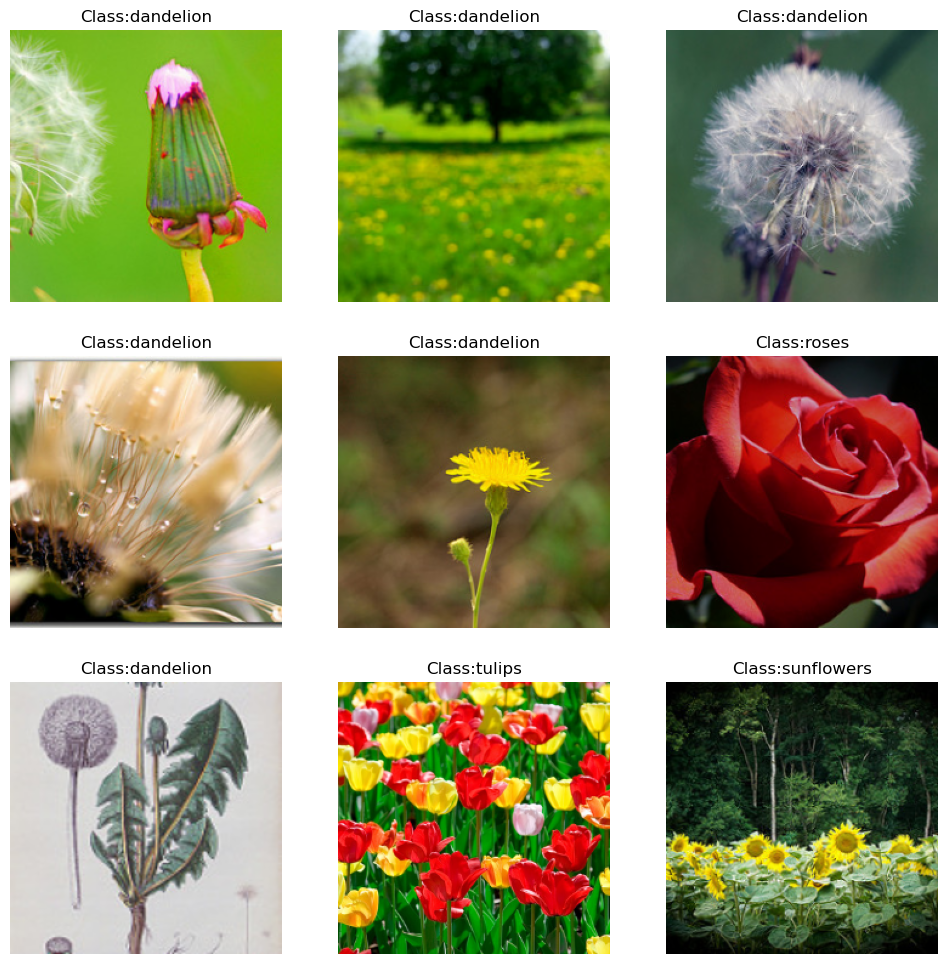

In [47]:
plt.figure(figsize=(12,12))
for X_batch ,y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3,3,index+1)
        plt.imshow((X_batch[index]+1)/2)
        plt.title(f"Class:{class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

load the pretrained model 

In [48]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                            include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(n_classes,activation="softmax")(avg)
model=tf.keras.Model(inputs=base_model.input,outputs=output)

In [49]:
for layer in base_model.layers:
    layer.trainable = False

let train the model for few epochs , while keeping the base model weights fixed

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,validation_data=valid_set,epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7024 - loss: 1.0157 - val_accuracy: 0.8403 - val_loss: 0.7377
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9055 - loss: 0.3700 - val_accuracy: 0.8367 - val_loss: 0.8186
Epoch 3/3
57/86 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.9388 - loss: 0.1968

KeyboardInterrupt: 

In [52]:
for indices in zip(range(33),range(33,66),range(66,99),range(99,132)):
    for idx in indices:
        print(f"{idx:3}:{base_model.layers[idx].name:22}",end="")
    print()

  0:input_layer_1          33:block4_pool            66:block8_sepconv1_act    99:block11_sepconv2_act  
  1:block1_conv1           34:batch_normalization_2  67:block8_sepconv1       100:block11_sepconv2      
  2:block1_conv1_bn        35:add_2                  68:block8_sepconv1_bn    101:block11_sepconv2_bn   
  3:block1_conv1_act       36:block5_sepconv1_act    69:block8_sepconv2_act   102:block11_sepconv3_act  
  4:block1_conv2           37:block5_sepconv1        70:block8_sepconv2       103:block11_sepconv3      
  5:block1_conv2_bn        38:block5_sepconv1_bn     71:block8_sepconv2_bn    104:block11_sepconv3_bn   
  6:block1_conv2_act       39:block5_sepconv2_act    72:block8_sepconv3_act   105:add_9                 
  7:block2_sepconv1        40:block5_sepconv2        73:block8_sepconv3       106:block12_sepconv1_act  
  8:block2_sepconv1_bn     41:block5_sepconv2_bn     74:block8_sepconv3_bn    107:block12_sepconv1      
  9:block2_sepconv2_act    42:block5_sepconv3_act    75

In [53]:
for layer in base_model.layers[56:]:
    layer.trainable= True
optimizer=  tf.keras.optimizers.SGD(learning_rate=0.01 , momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics =["accuracy"])
history = model.fit(train_set,validation_data=valid_set,epochs=2)

Epoch 1/2
86/86 ━━━━━━━━━━━━━━━━━━━━ 458s 5s/step - accuracy: 0.8716 - loss: 0.3769 - val_accuracy: 0.8748 - val_loss: 0.5887
Epoch 2/2
86/86 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.9869 - loss: 0.0421 - val_accuracy: 0.9002 - val_loss: 0.4188


### Classification and Localization

In [56]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes,activation="softmax")(avg)
loc_output=tf.keras.layers.Dense(4)(avg)
model=tf.keras.Model(inputs=base_model.input,
                     outputs =[class_output,loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy","mse"],
              loss_weights=[0.8,0.2],
              optimizer=optimizer,metrics=["accuracy","mse"])

In [60]:
# extra code - fit the model using random target bounding boxes 
def add_random_bounding_boxes(images,labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0],4])
    return images,(labels,fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set,epochs=2)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - dense_5_accuracy: 0.2110 - dense_5_loss: 1.3011 - dense_6_loss: 0.0753 - dense_6_mse: 0.3765 - loss: 1.3764
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - dense_5_accuracy: 0.5421 - dense_5_loss: 0.9586 - dense_6_loss: 0.0388 - dense_6_mse: 0.1939 - loss: 0.9974


### Extra material -How MAp relates to Precision/Recall

In [61]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

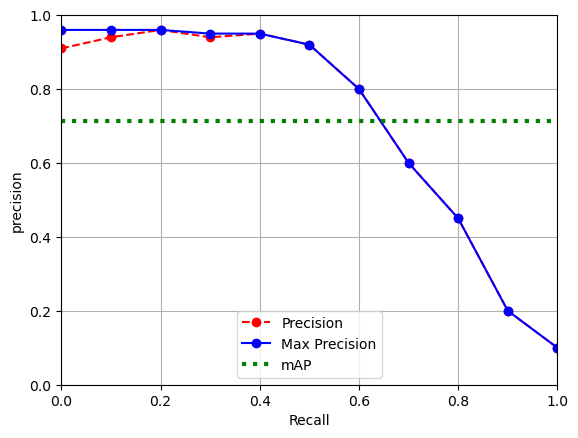

In [66]:
recalls = np.linspace(0, 1, 11)
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls,precisions,"ro--",label="Precision")
plt.plot(recalls,max_precisions,"bo-",label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("precision")
plt.plot([0,1],[mAP,mAP],"g:",linewidth=3,label="mAP")
plt.grid(True)
plt.axis([0,1,0,1])
plt.legend(loc="lower center")
plt.show()